# Distribution de la neige simulée par les modèles (figure AR4)

In [1]:
from watermark import watermark
%load_ext watermark
print(watermark())

Last updated: 2025-06-06T12:53:47.183563+00:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.17.2

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
from skimage.measure import find_contours
import os
import calendar
from matplotlib import cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mpl

In [3]:
%watermark --iversions

pandas    : 2.2.3
matplotlib: 3.10.0
numpy     : 2.0.2
skimage   : 0.25.0
xarray    : 2025.1.1
watermark : 2.5.0
cartopy   : 0.24.0



## Définition des fonctions

In [4]:
def get_data(path_snc, path_areacella, path_sftlf):
    ds_snc = xr.open_dataset(path_snc)
    ds_area = xr.open_dataset(path_areacella)
    ds_sftlf = xr.open_dataset(path_sftlf)
    return ds_snc, ds_area, ds_sftlf

def extraction_variable_and_monthly_mean(ds_snc, variable="snc", start_year="1995", end_year="2014", lat_min=20):
    snc = ds_snc[variable].sel(time=slice(start_year, end_year))

    if lat_min is not None:
        snc = snc.sel(lat=snc.lat >= lat_min)

    snc = snc.where(snc < 1e19, float("nan"))

    max_val = snc.max().item()
    if max_val > 1.5:
        print(f"La variable '{variable}' est en %. Conversion en fraction.")
        snc = snc / 100

    if sftlf is not None:
        snc=snc.where(sftlf>0)

    snc = snc.clip(0, 1)

    snow_cover = snc.groupby("time.month").mean(dim="time")
    monthly_mean = snow_cover.mean(dim=("lat", "lon"))

    return snc, snow_cover, monthly_mean

def binary_mask_from_snc(snow_cover, threshold=0.15):
    mask = xr.where(snow_cover > threshold, 1, 0)
    return mask

def snow_surface_calculation(snow_cover, areacella):
    area_km2 = areacella * 1e-6
    snow_cover_km2 = (snow_cover * area_km2).groupby(snow_cover["month"]).sum(dim=["lat", "lon"], skipna=True)
    return snow_cover_km2

#def plot_snow_cover_initial(snc, time_index=0, title="Carte couverture neigeuse"):
    #plt.figure(figsize=(10, 5))
    #ax = plt.axes(projection=ccrs.PlateCarree())
    #snc.isel(time=time_index).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
    #ax.coastlines()
    #plt.title(title)
    #plt.show()

def plot_snow_cover_initial(snc, time_index=0, title="Carte couverture neigeuse", ax=None):
    if ax is None:
        plt.figure(figsize=(10, 5))
        ax = plt.axes(projection=ccrs.PlateCarree())
        show_plot = True
    else:
        show_plot = False
        
    snc.isel(time=time_index).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
    ax.coastlines()
    ax.set_title(title)

    if show_plot:
        plt.show

def plot_binary_mask(binary_mask, month=1, title="Carte couverture neigeuse", ax=None):
    if ax is None:
        plt.figure(figsize=(10, 5))
        ax = plt.axes(projection=ccrs.PlateCarree())
        show_plot = True
    else:
        show_plot = False
        
    binary_mask.isel(month=month).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
    ax.coastlines()
    ax.set_title(title)

    if show_plot:
        plt.show

def plot_monthly_mean(monthly_mean, xlabel="Mois", ylabel="Average Snow Cover", title="Monthly average snow cover"):
    plt.plot(range(1, 13), monthly_mean, marker="o")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()

def plot_surface_km2(snow_cover_km2, xlabel="Mois", ylabel="Snowy surface (km2)", title="Average monthly snow cover area"):
    plt.plot(range(1, 13), snow_cover_km2, marker="o")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()

In [5]:
files = os.listdir("/home/jovyan/private-storage/interp_models_hist_bis/")

nc_files = [filename for filename in files if filename.endswith(".nc")]
nc_files

['IPSL-CM6A-LR_hist_reprojete.nc',
 'BCC-CSM2-MR_hist_reprojete.nc',
 'CanESM5_hist_reprojete.nc',
 'CanESM5-CanOE_hist_reprojete.nc',
 'CESM2_hist_reprojete.nc',
 'CESM2-WACCM_hist_reprojete.nc',
 'CIESM_hist_reprojete.nc',
 'CNRM-CM6-1_hist_reprojete.nc',
 'CNRM-CM6-1-HR_hist_reprojete.nc',
 'CNRM-ESM2-1_hist_reprojete.nc',
 'EC-Earth3_hist_reprojete.nc',
 'EC-Earth3-Veg_hist_reprojete.nc',
 'FGOALS-f3-L_hist_reprojete.nc',
 'FGOALS-g3_hist_reprojete.nc',
 'GFDL-CM4_hist_reprojete.nc',
 'GISS-E2-1-G_hist_reprojete.nc',
 'HadGEM3-GC31-LL_hist_reprojete.nc',
 'MIROC-ES2L_hist_reprojete.nc',
 'MIROC6_hist_reprojete.nc',
 'MPI-ESM1-2-HR_hist_reprojete.nc',
 'MPI-ESM1-2-LR_hist_reprojete.nc',
 'MRI-ESM2-0_hist_reprojete.nc',
 'NorESM2-LM_hist_reprojete.nc',
 'NorESM2-MM_hist_reprojete.nc',
 'UKESM1-0-LL_hist_reprojete.nc']

In [6]:
excluded_models = ["FGOALS-f3-L", "FGOALS-g3", "CIESM"]

filtered_nc_files = [f for f in nc_files if not any(model in f for model in excluded_models)]

## Snow reference

In [7]:
path_snow_ref = os.path.join("~/private-storage/output_data/", "snow_reference.nc")
snow_ref = xr.open_dataset(path_snow_ref)
snow_ref = snow_ref["snow_cover_extent"]
snow_ref

<xarray.DataArray 'snow_cover_extent' (month: 12, lat: 180, lon: 360)> Size: 3MB
[777600 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  surface_snow_binary_mask
    long_name:      NOAA/NCEI Climate Data Record of snow cover extent
    cell_methods:   time: mean
    flag_values:    [0 1]
    flag_meanings:  no_snow snow_covered

In [8]:
path = "/home/jovyan/private-storage/grid/"
file = "area.nc"
area = xr.open_dataset(os.path.join(path, file))

In [9]:
season_months = {
    "DJF": [12, 1, 2],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11]
}

In [10]:
seasonal_snow_reference = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = snow_ref.sel(month=months_float)
    seasonal_snow_reference[season] = da_sel.mean(dim="month", skipna=True)

In [11]:
djf_snow_reference = seasonal_snow_reference['DJF']
mam_snow_reference = seasonal_snow_reference['MAM']
jja_snow_reference = seasonal_snow_reference['JJA']
son_snow_reference = seasonal_snow_reference['SON']

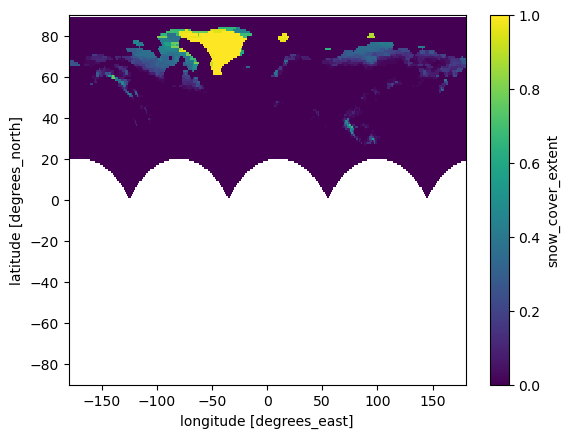

In [12]:
jja_snow_reference.plot()

## Cartes binaires pour chaque modèle

La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 'snc' est en %. Conversion en fraction.
La variable 

/tmp/ipykernel_120/2187209873.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


La variable 'snc' est en %. Conversion en fraction.


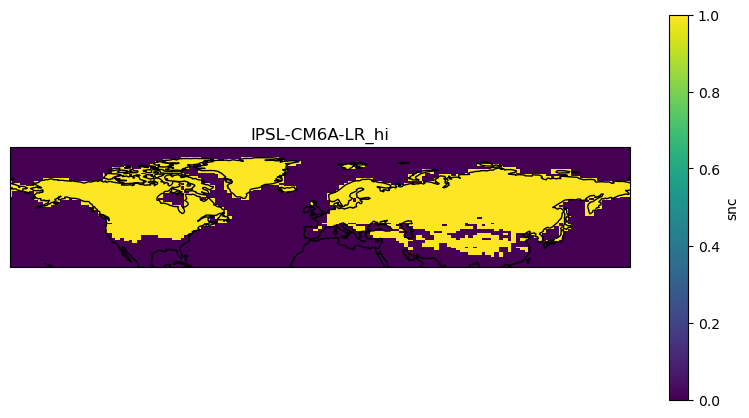

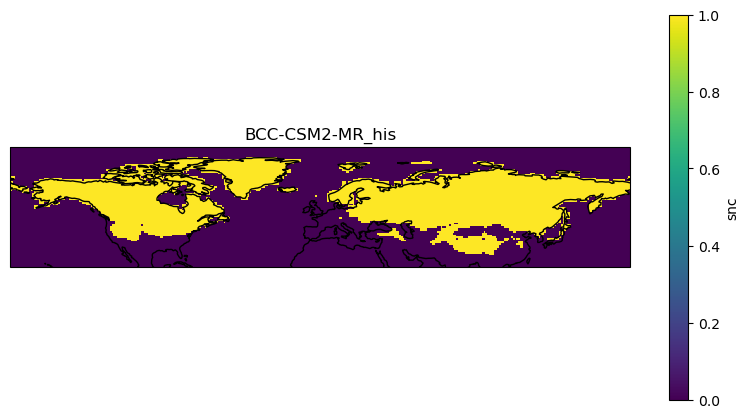

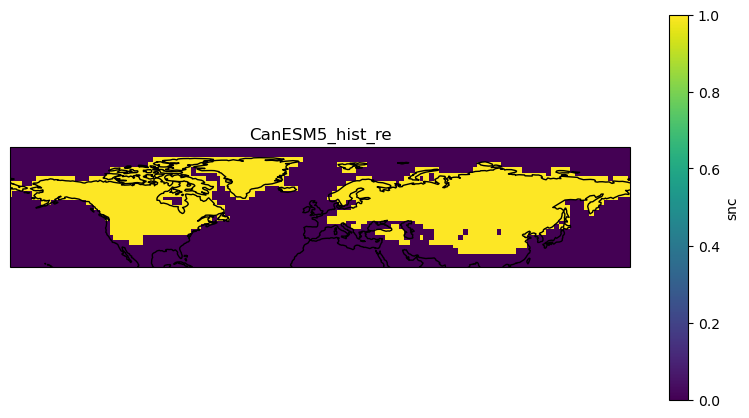

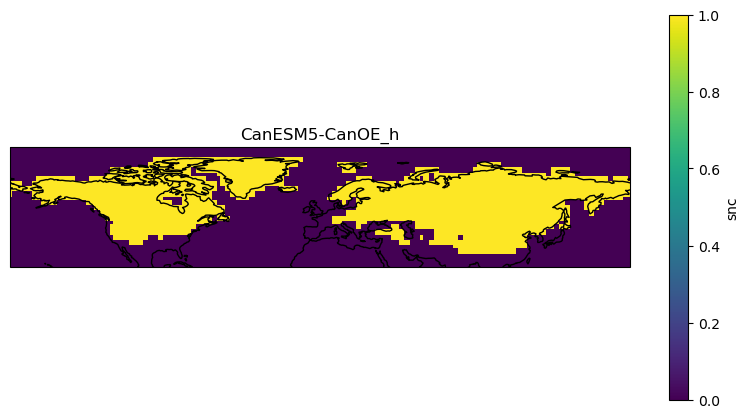

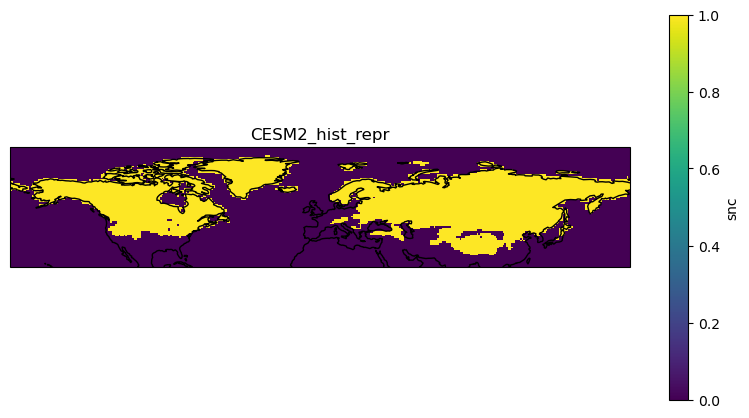

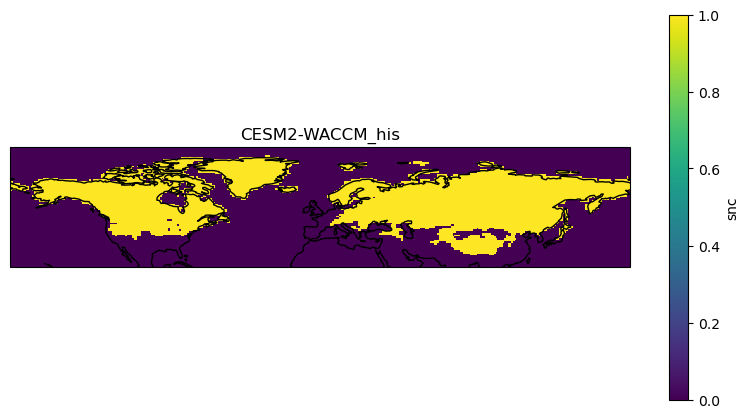

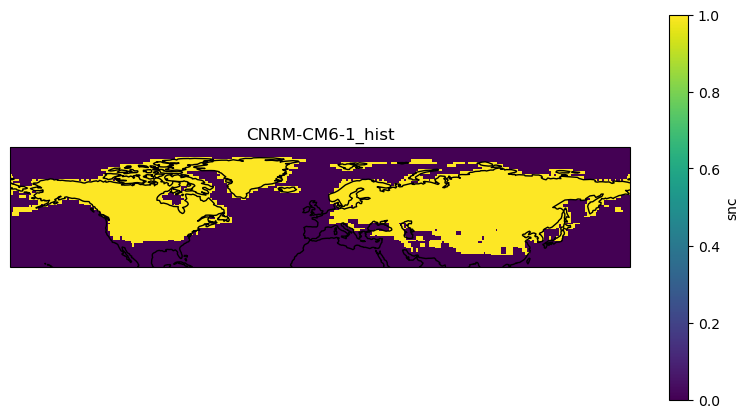

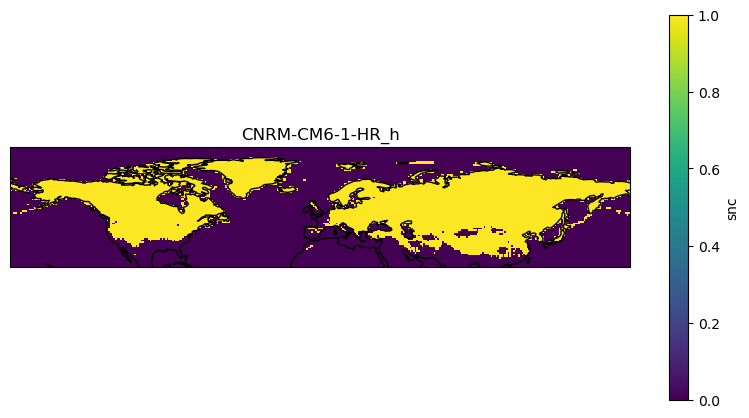

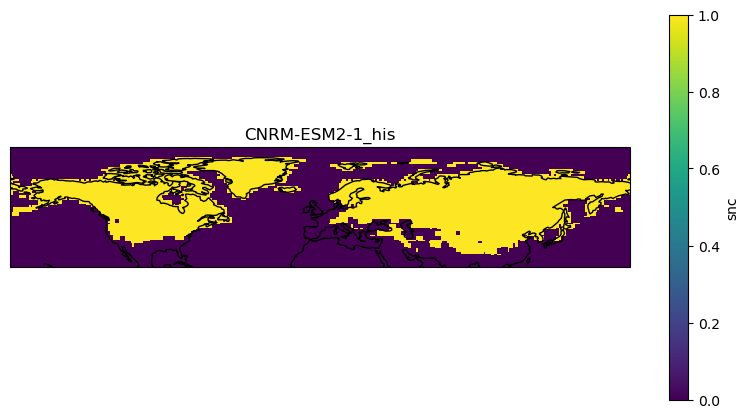

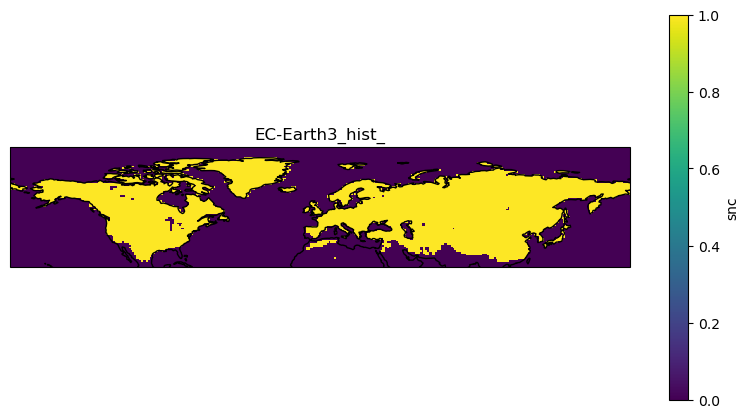

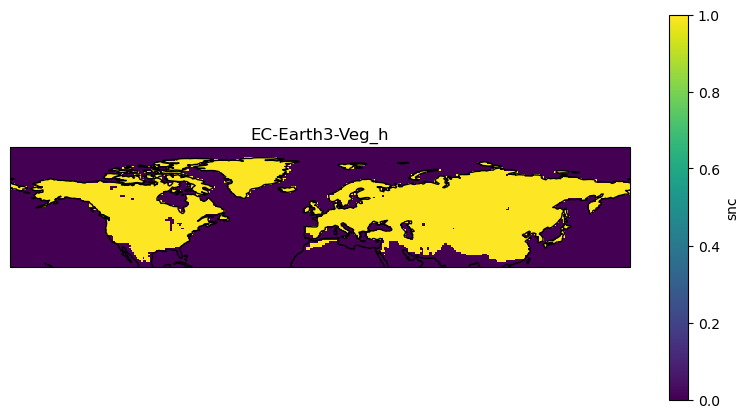

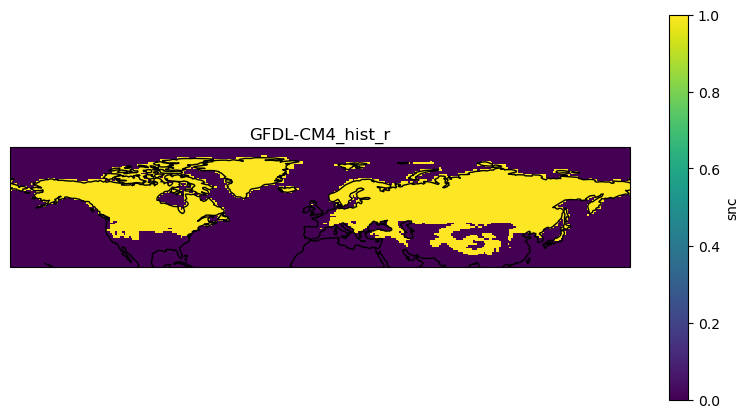

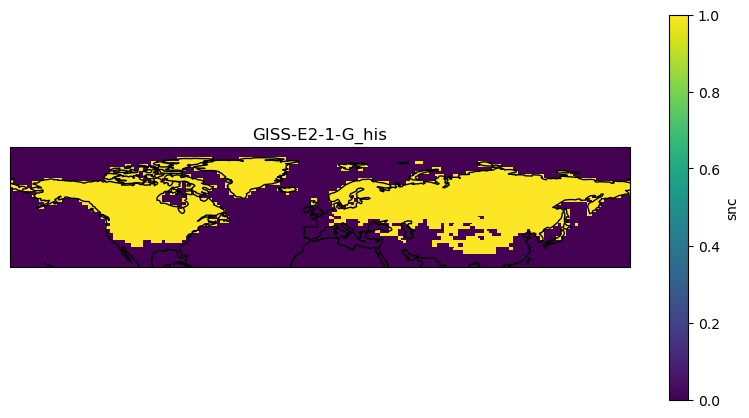

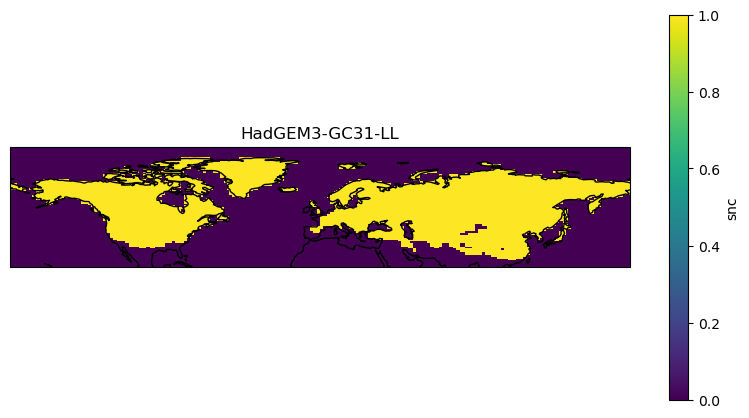

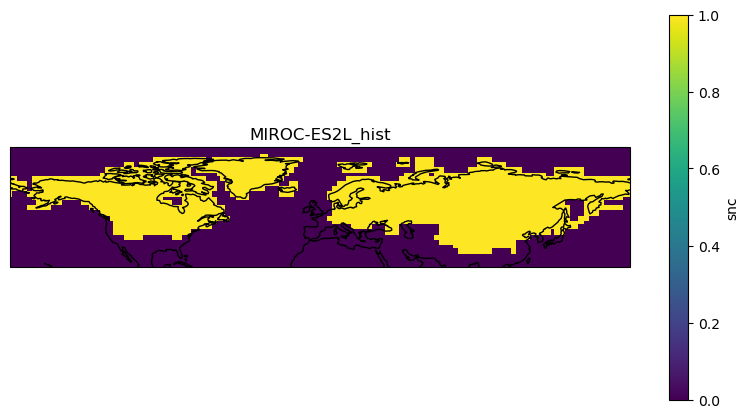

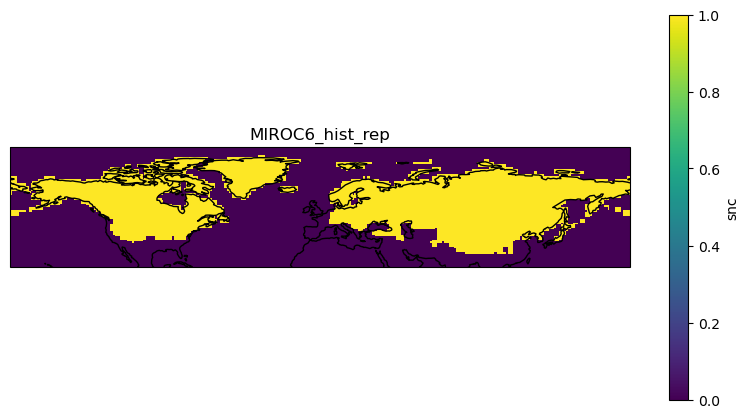

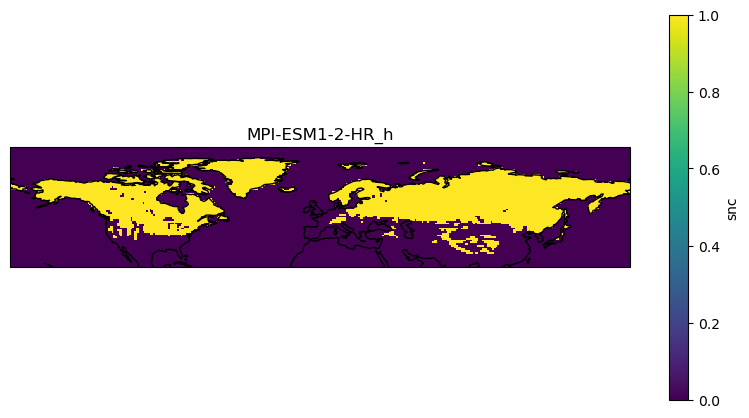

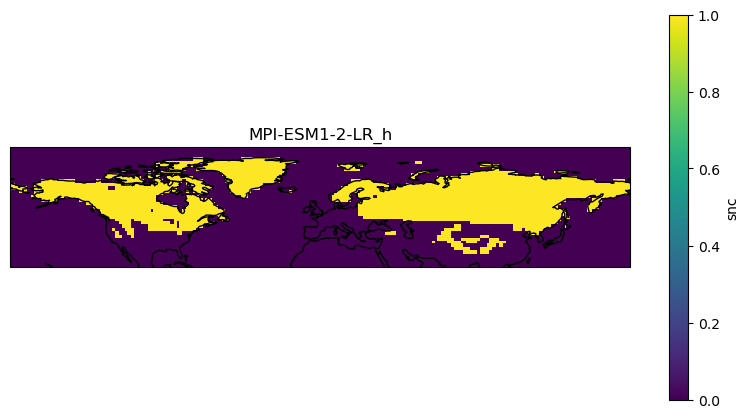

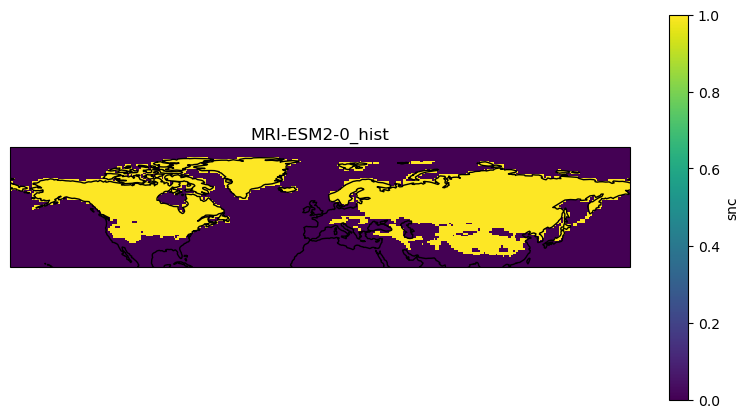

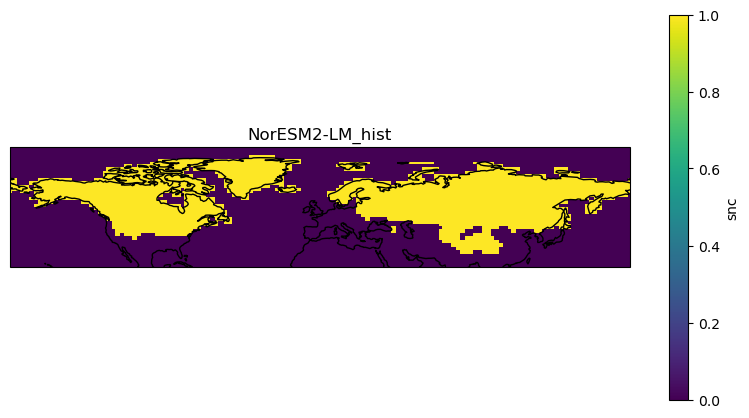

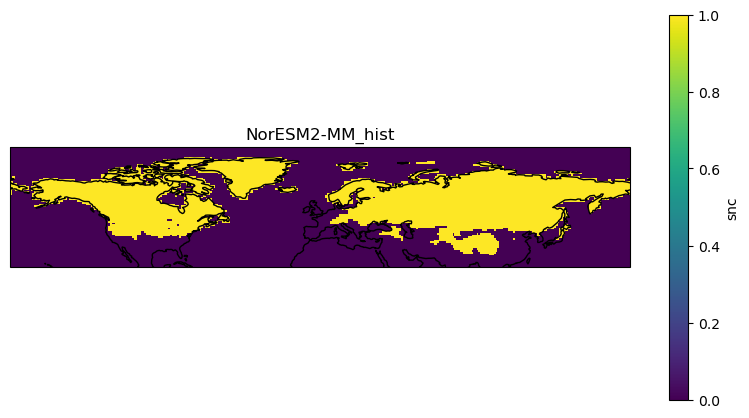

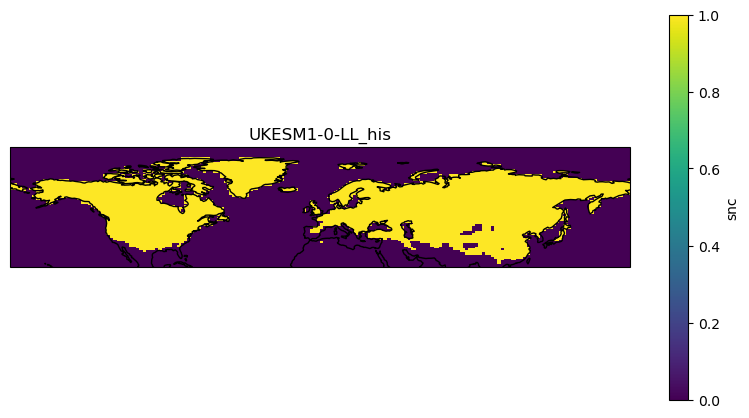

In [13]:
snow_cover_dict = {}

for i, files in enumerate(filtered_nc_files):
    model_name = files.split("_")[0]
    
    path_snc = os.path.join("/home/jovyan/private-storage/interp_models_hist_bis/", files)
    path_areacella = os.path.join("/home/jovyan/private-storage/areacella_recalcule_cdo_bis/", files.replace("hist_reprojete", "gridarea_hist_recalcule"))
    path_sftlf = os.path.join("/home/jovyan/private-storage/interp_sftlf_bis/", files.replace("hist", "sftlf"))
                                 
    ds_snc, ds_area, ds_sftlf = get_data(path_snc, path_areacella, path_sftlf)
    sftlf = ds_sftlf["sftlf"]
    snc, snow_cover, monthly_mean = extraction_variable_and_monthly_mean(ds_snc)
    binary_mask = binary_mask_from_snc(snow_cover)

    areacella = ds_area["cell_area"]
    snow_cover_km2 = snow_surface_calculation(snow_cover, areacella)
    snow_cover_dict[model_name] = binary_mask

    #ax = axes[i]
    plot_binary_mask(binary_mask, title=files[:15])

    #print(snow_cover_km2)
    
    ds_snc.close()
    ds_area.close()

    #break

In [14]:
for model, da in snow_cover_dict.items():
    if 'type' in da.coords:
        print(f"{model}: {da['type'].values}")

IPSL-CM6A-LR: b'typeland'
CanESM5: b'land'
CNRM-CM6-1: b'typeland'
CNRM-CM6-1-HR: b'typeland'
CNRM-ESM2-1: b'typeland'
GISS-E2-1-G: b'land'
HadGEM3-GC31-LL: b'land'
MIROC-ES2L: b'land'
MIROC6: b'land'
MRI-ESM2-0: b'land'
UKESM1-0-LL: b'land'


In [15]:
cleaned_snc = []
model_names = []

for model, da in snow_cover_dict.items():
    if 'type' in da.coords:
        da = da.drop_vars('type')

    cleaned_snc.append(da)
    model_names.append(model)

In [16]:
all_snc = xr.concat(cleaned_snc, dim=xr.DataArray(model_names, dims="model"))

monthly_sum = all_snc.sum(dim="model")

In [17]:
path_sftlf = os.path.join("/home/jovyan/private-storage/interp_sftlf_bis/", "MRI-ESM2-0_sftlf_reprojete.nc")

sftlf = xr.open_dataset(path_sftlf)
sftlf = sftlf["sftlf"]

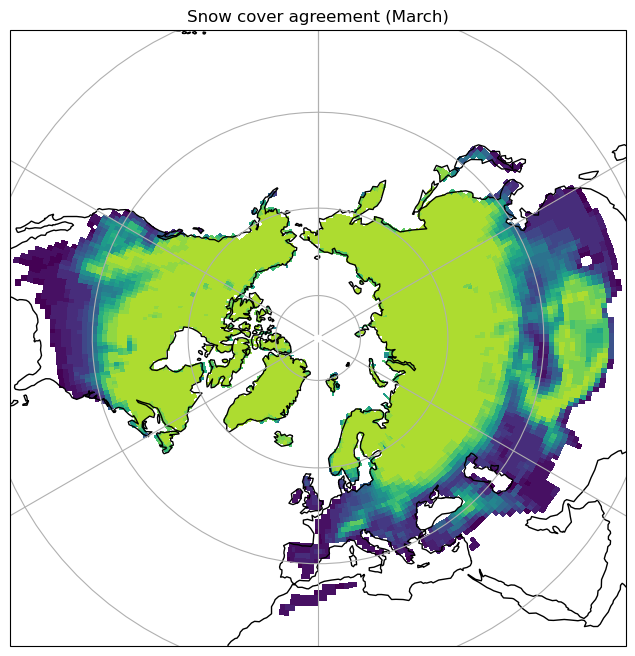

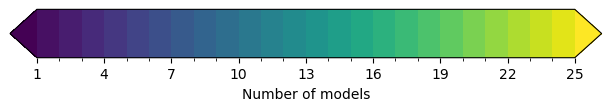

In [18]:
month_idx = 2  # mars
data = monthly_sum.isel(month=month_idx)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

# choisir la bonne grille
landmask = sftlf > 50
data_plot = data.where((data > 0) & (landmask))

# plot
mesh = ax.pcolormesh(
    data_plot['lon'],
    data_plot['lat'],
    data_plot,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    vmin=1,
    vmax=25
)

ax.coastlines()
ax.gridlines(draw_labels=False)
ax.set_extent([-180, 180, 25, 90], ccrs.PlateCarree())

plt.title("Snow cover agreement (March)")

# couleurs
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

cmap = mpl.cm.viridis
bounds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Number of models")

#plt.tight_layout()
plt.show()

## Création d'une carte par saison

In [19]:
# définition des saisons
season_months = {
    "DJF": [12, 1, 2],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11]
}

In [20]:
seasonal_sum = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = monthly_sum.sel(month=months_float)
    seasonal_sum[season] = da_sel.mean(dim="month", skipna=True)

In [21]:
seasonal_sum_DJF = seasonal_sum['DJF']
seasonal_sum_MAM = seasonal_sum['MAM']
seasonal_sum_JJA = seasonal_sum['JJA']
seasonal_sum_SON = seasonal_sum['SON']

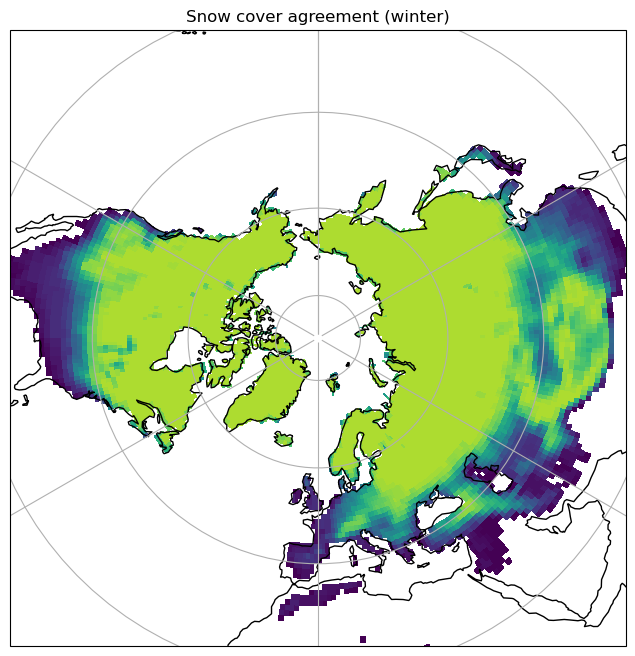

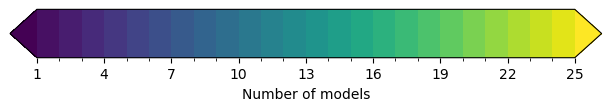

In [22]:
data = seasonal_sum_DJF

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

# choisir la bonne grille
landmask = sftlf > 50
data_plot = data.where((data > 0) & (landmask))

# plot
mesh = ax.pcolormesh(
    data_plot['lon'],
    data_plot['lat'],
    data_plot,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    vmin=1,
    vmax=25
)

ax.coastlines()
ax.gridlines(draw_labels=False)
ax.set_extent([-180, 180, 25, 90], ccrs.PlateCarree())

plt.title("Snow cover agreement (winter)")

# couleurs
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

cmap = mpl.cm.viridis
bounds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Number of models")

#plt.tight_layout()
plt.show()

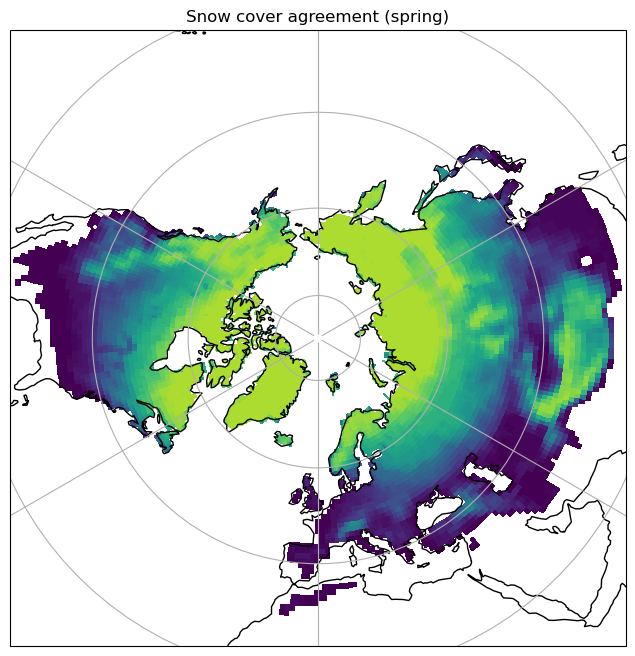

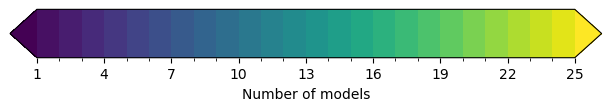

In [23]:
data = seasonal_sum_MAM

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

# choisir la bonne grille
landmask = sftlf > 50
data_plot = data.where((data > 0) & (landmask))

# plot
mesh = ax.pcolormesh(
    data_plot['lon'],
    data_plot['lat'],
    data_plot,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    vmin=1,
    vmax=25
)

ax.coastlines()
ax.gridlines(draw_labels=False)
ax.set_extent([-180, 180, 25, 90], ccrs.PlateCarree())

plt.title("Snow cover agreement (spring)")

# couleurs
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

cmap = mpl.cm.viridis
bounds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Number of models")

#plt.tight_layout()
plt.show()

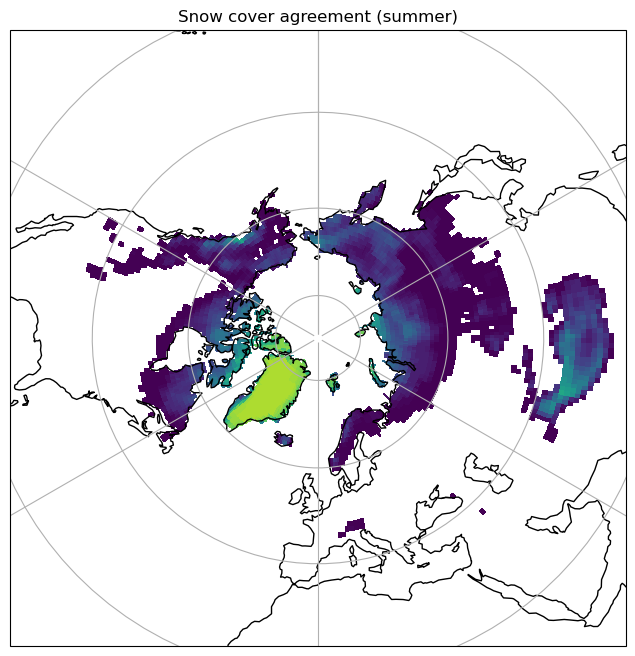

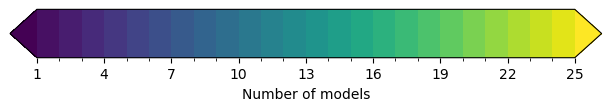

In [24]:
data = seasonal_sum_JJA

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

# choisir la bonne grille
landmask = sftlf > 50
data_plot = data.where((data > 0) & (landmask))

# plot
mesh = ax.pcolormesh(
    data_plot['lon'],
    data_plot['lat'],
    data_plot,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    vmin=1,
    vmax=25
)

ax.coastlines()
ax.gridlines(draw_labels=False)
ax.set_extent([-180, 180, 25, 90], ccrs.PlateCarree())

plt.title("Snow cover agreement (summer)")

# couleurs
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

cmap = mpl.cm.viridis
bounds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Number of models")

#plt.tight_layout()
plt.show()

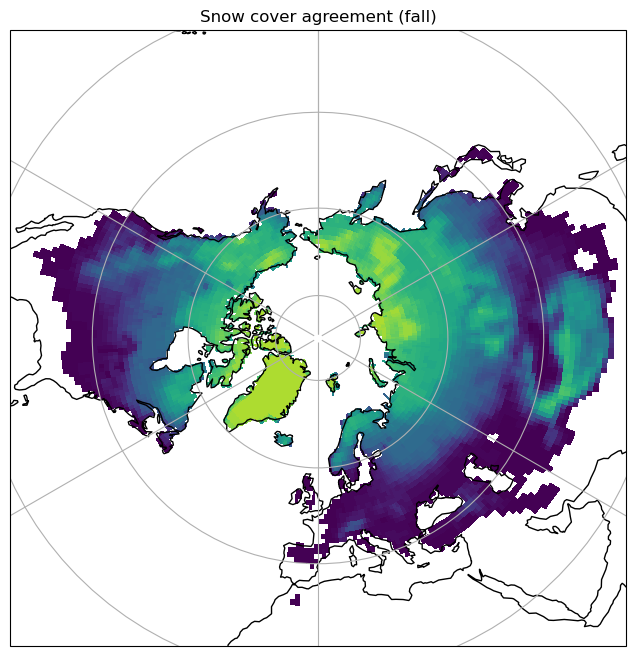

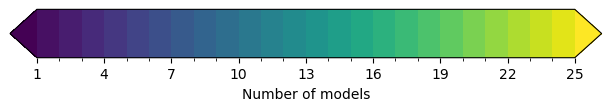

In [25]:
data = seasonal_sum_SON

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

# choisir la bonne grille
landmask = sftlf > 50
data_plot = data.where((data > 0) & (landmask))

# plot
mesh = ax.pcolormesh(
    data_plot['lon'],
    data_plot['lat'],
    data_plot,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    vmin=1,
    vmax=25
)

ax.coastlines()
ax.gridlines(draw_labels=False)
ax.set_extent([-180, 180, 25, 90], ccrs.PlateCarree())

plt.title("Snow cover agreement (fall)")

# couleurs
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

cmap = mpl.cm.viridis
bounds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Number of models")

#plt.tight_layout()
plt.show()

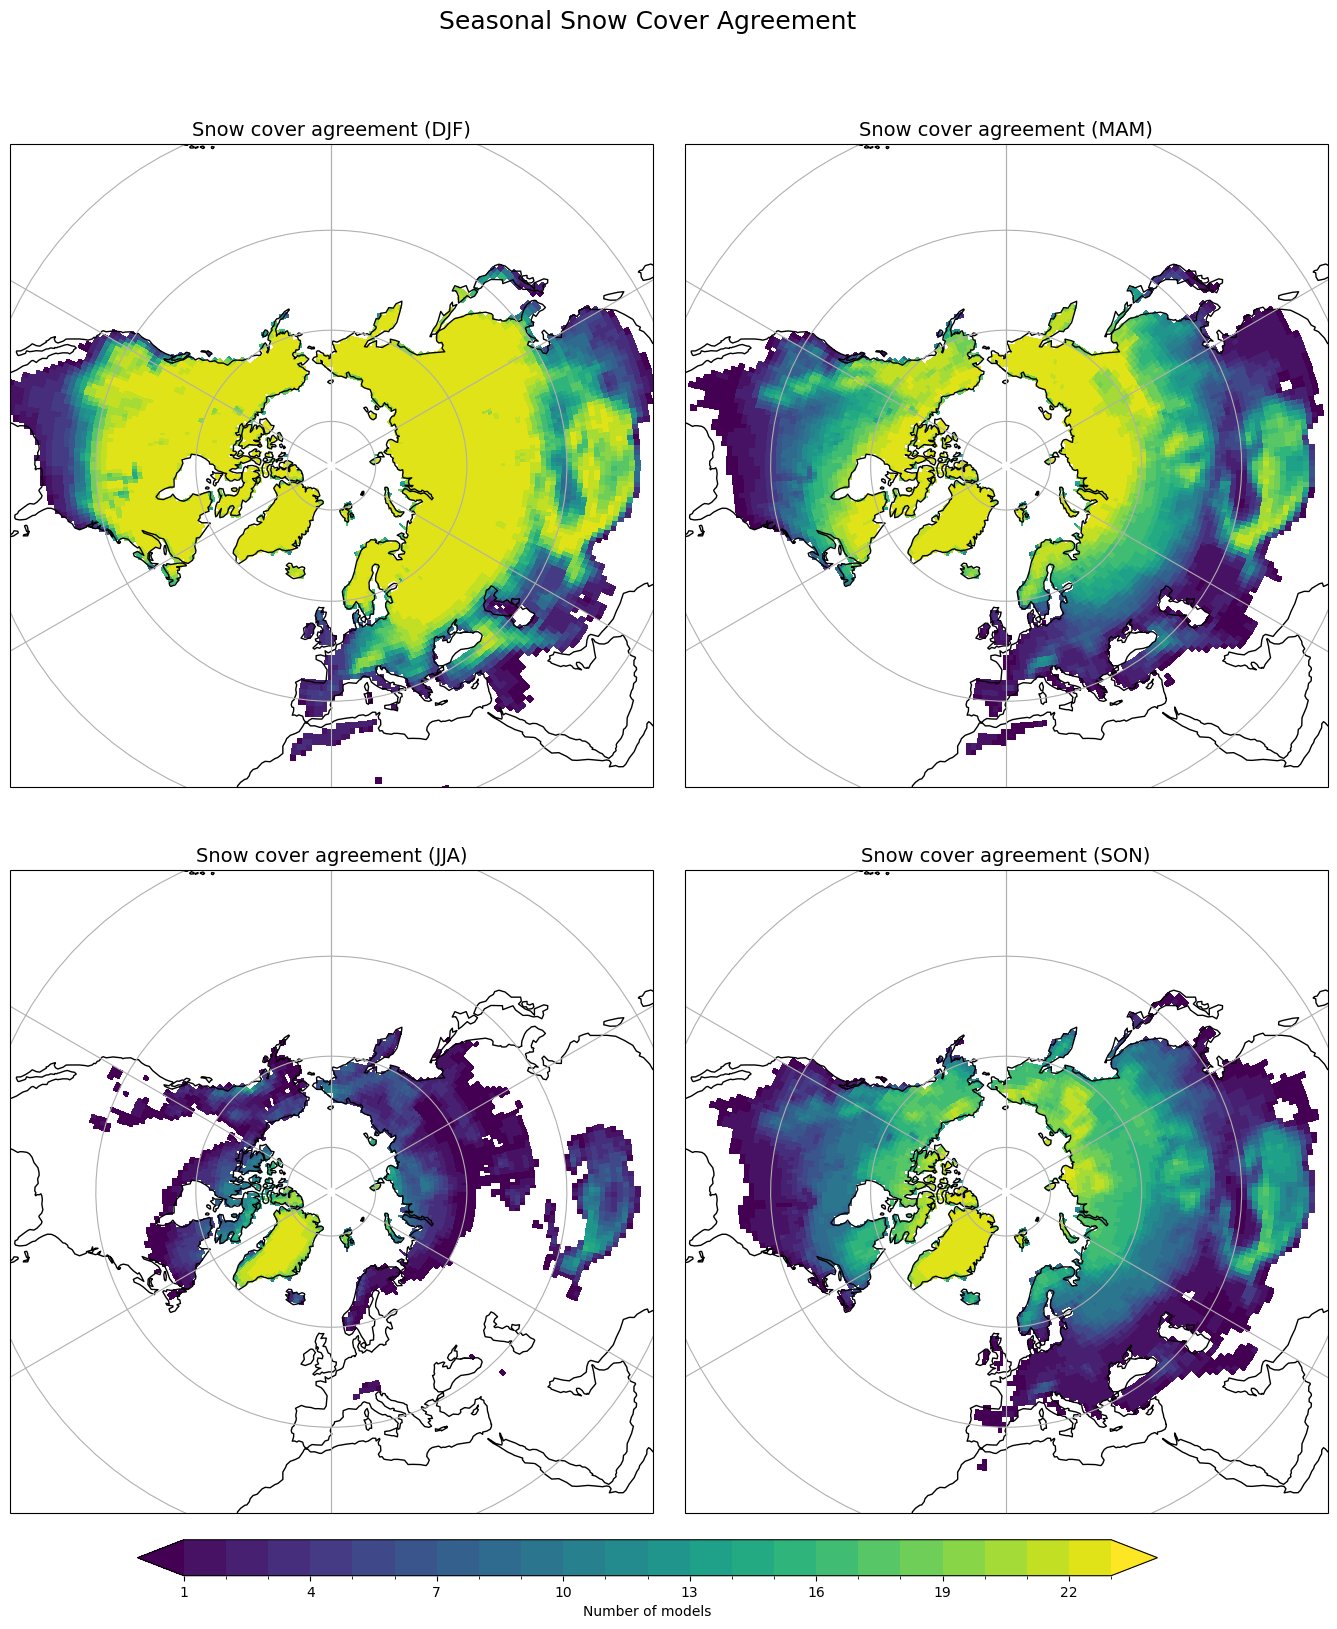

In [26]:
# Dictionnaire avec les données par saison
seasonal_data = {
    'DJF': seasonal_sum_DJF,
    'MAM': seasonal_sum_MAM,
    'JJA': seasonal_sum_JJA,
    'SON': seasonal_sum_SON
}

landmask = sftlf > 50

# Création de la figure et des axes
fig, axes = plt.subplots(2, 2, figsize=(17, 18), subplot_kw={'projection': ccrs.NorthPolarStereo()})
axes = axes.flatten()

# Paramètres couleur
cmap = mpl.cm.viridis
bounds = list(range(1, 24))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

# Tracer chaque saison
for ax, (season, data) in zip(axes, seasonal_data.items()):
    data_plot = data.where((data > 0) & (landmask))
    
    mesh = ax.pcolormesh(
        data_plot['lon'],
        data_plot['lat'],
        data_plot,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm
    )
    
    ax.set_title(f"Snow cover agreement ({season})", fontsize=14)
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    ax.set_extent([-180, 180, 25, 90], ccrs.PlateCarree())

# Colorbar
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])  # [left, bottom, width, height]
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cbar_ax, orientation='horizontal',
             label="Number of models")

# Ajustements de mise en page
plt.subplots_adjust(wspace=0.05, hspace=0.1)  # espace horizontal et vertical réduit
plt.suptitle("Seasonal Snow Cover Agreement", fontsize=18, y=0.95)

plt.show()


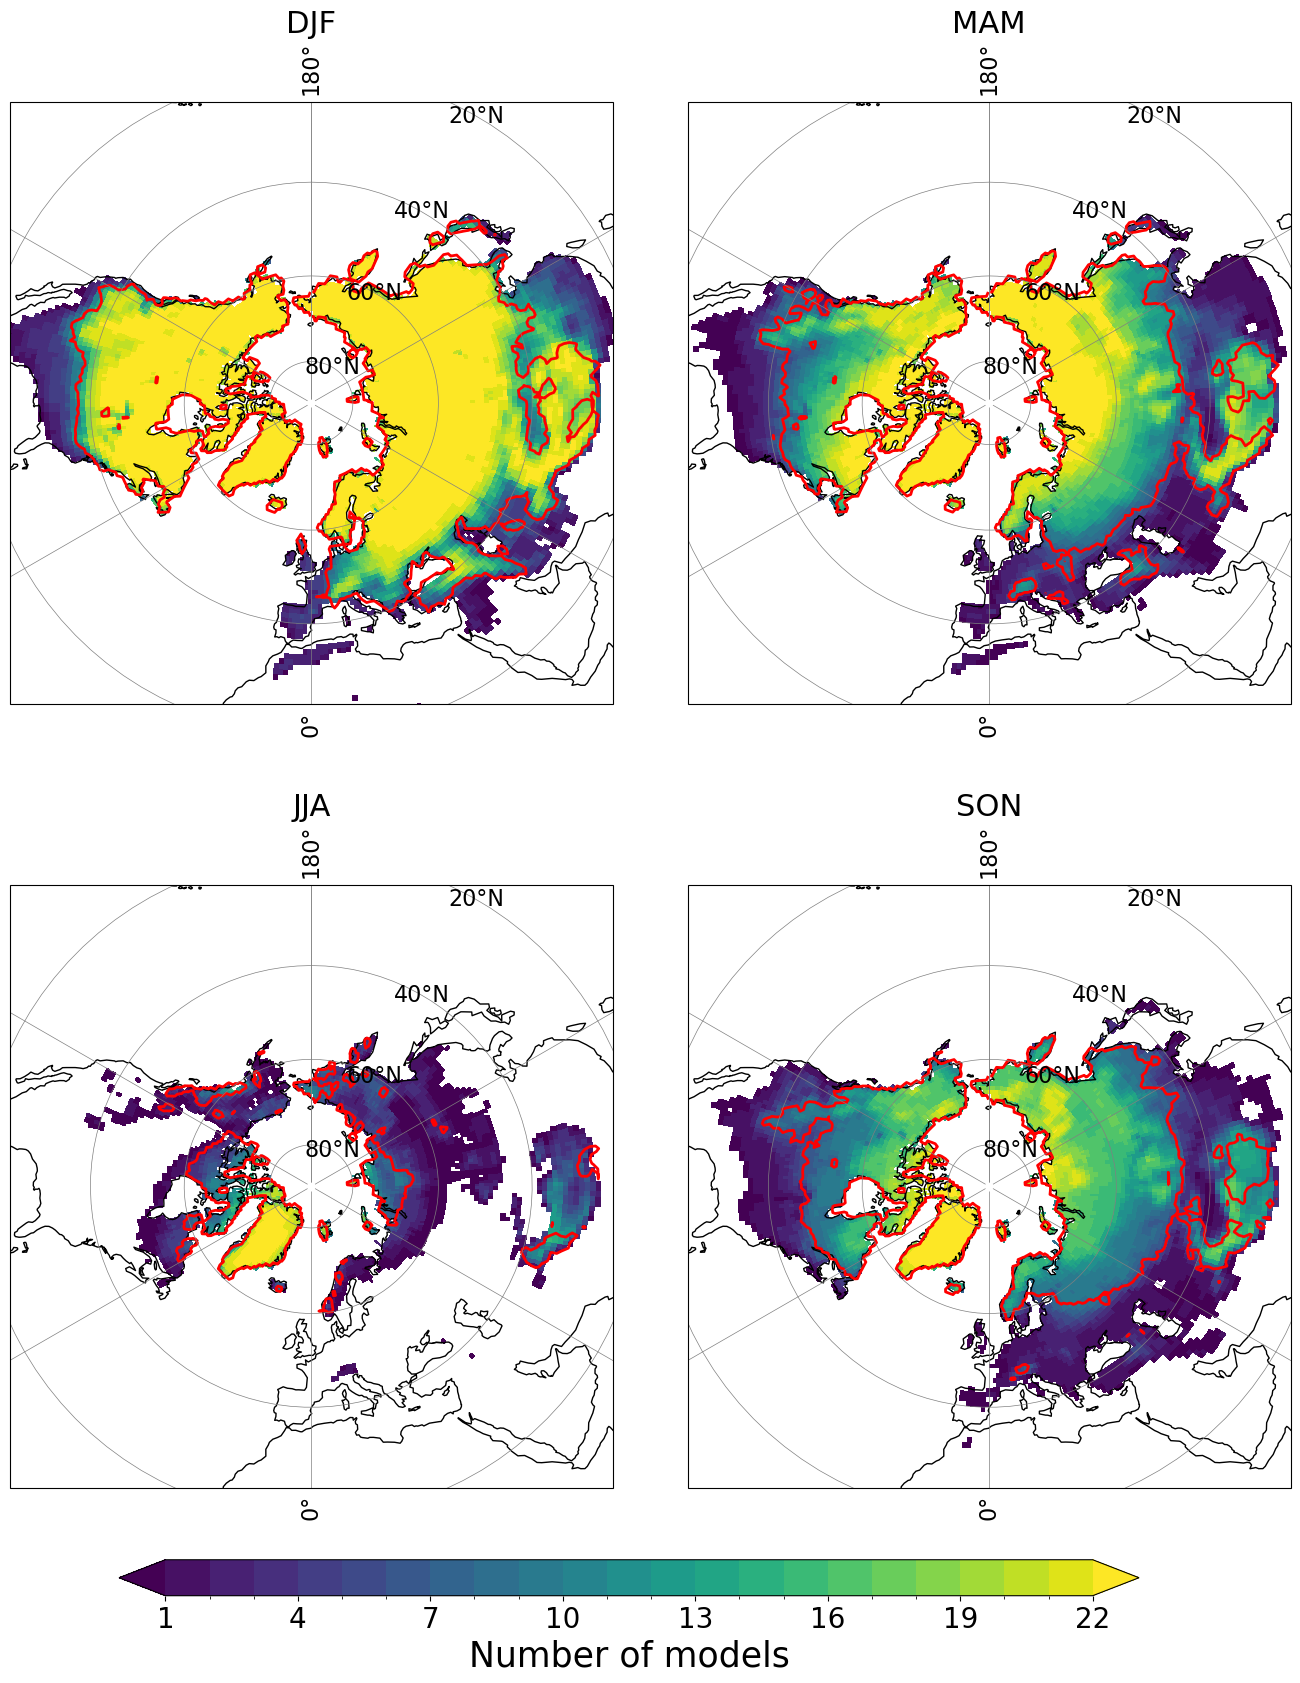

In [43]:
# Dictionnaires des valeurs par saison et référence
seasonal_data = {
    'DJF': seasonal_sum_DJF,
    'MAM': seasonal_sum_MAM,
    'JJA': seasonal_sum_JJA,
    'SON': seasonal_sum_SON
}

reference_data = {
    'DJF': djf_snow_reference,
    'MAM': mam_snow_reference,
    'JJA': jja_snow_reference,
    'SON': son_snow_reference
}

landmask = sftlf > 50

# figure
fig, axes = plt.subplots(2, 2, figsize=(17, 18), subplot_kw={'projection': ccrs.NorthPolarStereo()})
axes = axes.flatten()

# couleurs
cmap = mpl.cm.viridis
bounds = list(range(1, 23))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

# tracé des 4 saisons
for ax, (season, data) in zip(axes, seasonal_data.items()):
    ref = reference_data[season]
    data_plot = data.where((data > 0) & (landmask))
    
    mesh = ax.pcolormesh(
        data_plot['lon'],
        data_plot['lat'],
        data_plot,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm
    )

    # contour de la référence
    contour = ax.contour(
        ref['lon'],
        ref['lat'],
        ref,
        levels=[0.15],  # seuil pour tracer le contour
        colors='red',
        linewidths=2,
        transform=ccrs.PlateCarree()
    )

    ax.set_title(f"{season}", fontsize=22)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, color='gray', linewidth=0.5, linestyle='-')
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}
    ax.set_extent([-180, 180, 25, 90], ccrs.PlateCarree())

# Barre de couleur
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax,
    orientation='horizontal'
)
cbar.set_label("Number of models", fontsize=25)
cbar.ax.tick_params(labelsize=20)

# Ajustement mise en page
plt.subplots_adjust(wspace=0.06, hspace=0.3)

plt.savefig("snow_cover_agreement.png")

plt.show()

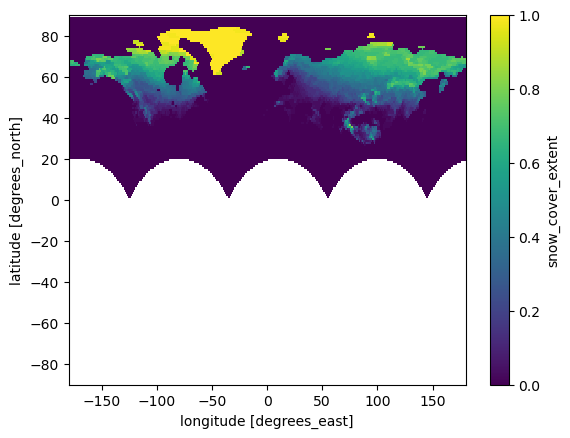

In [55]:
son_snow_reference.plot()

/tmp/ipykernel_2917/4161737850.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


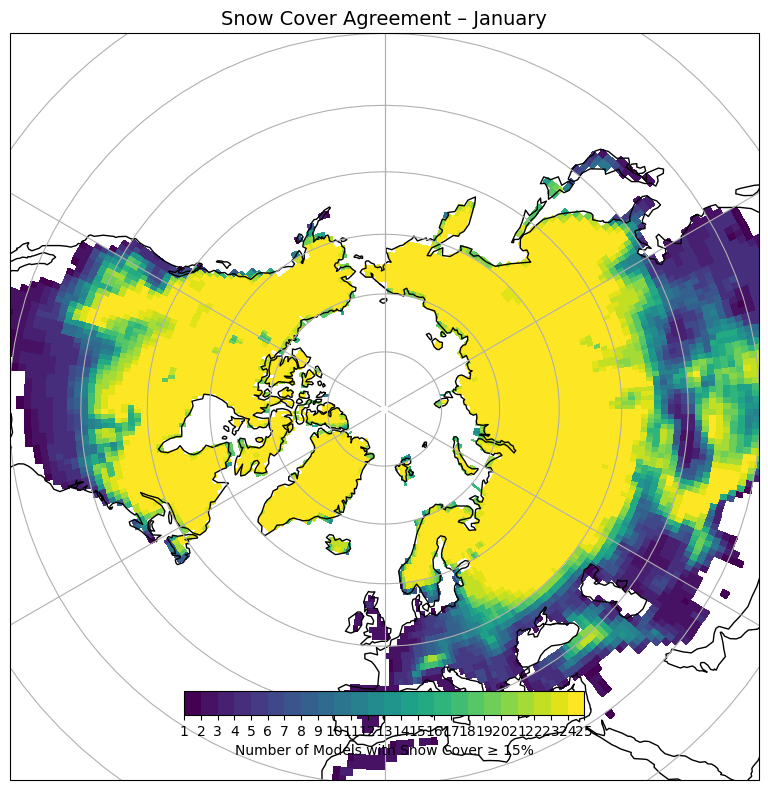

/tmp/ipykernel_2917/4161737850.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


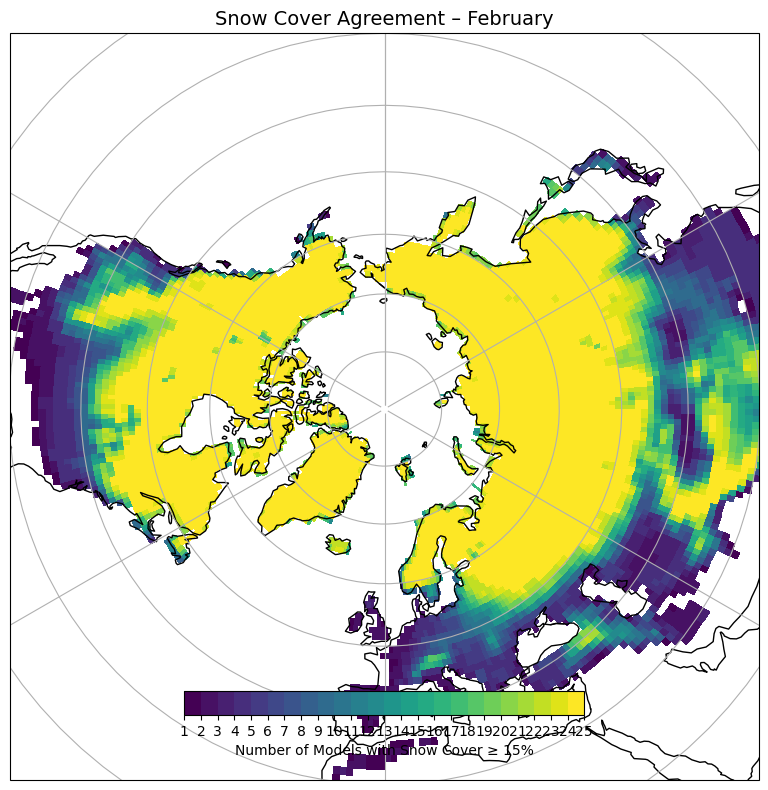

/tmp/ipykernel_2917/4161737850.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


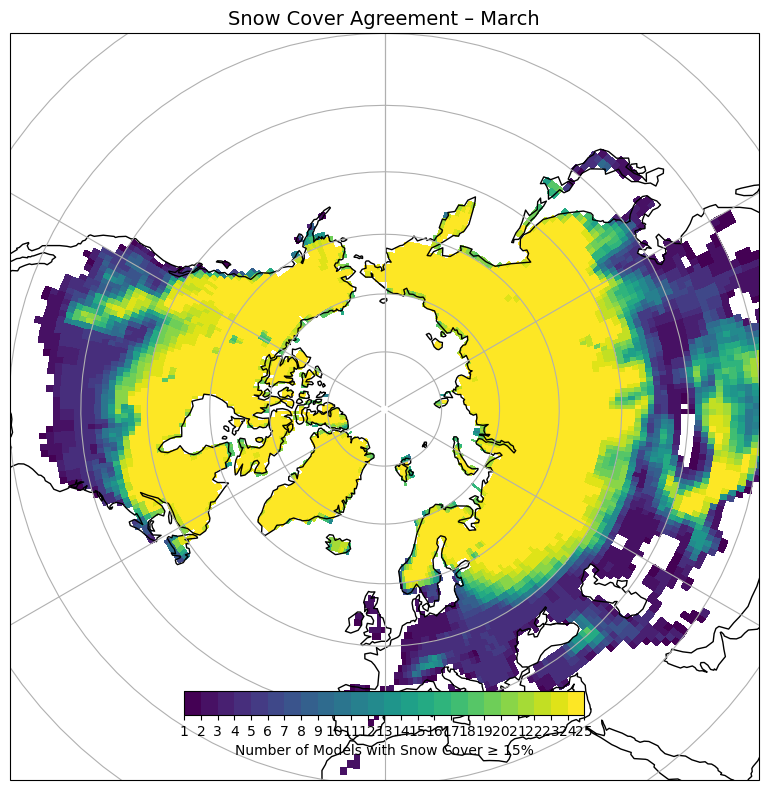

/tmp/ipykernel_2917/4161737850.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


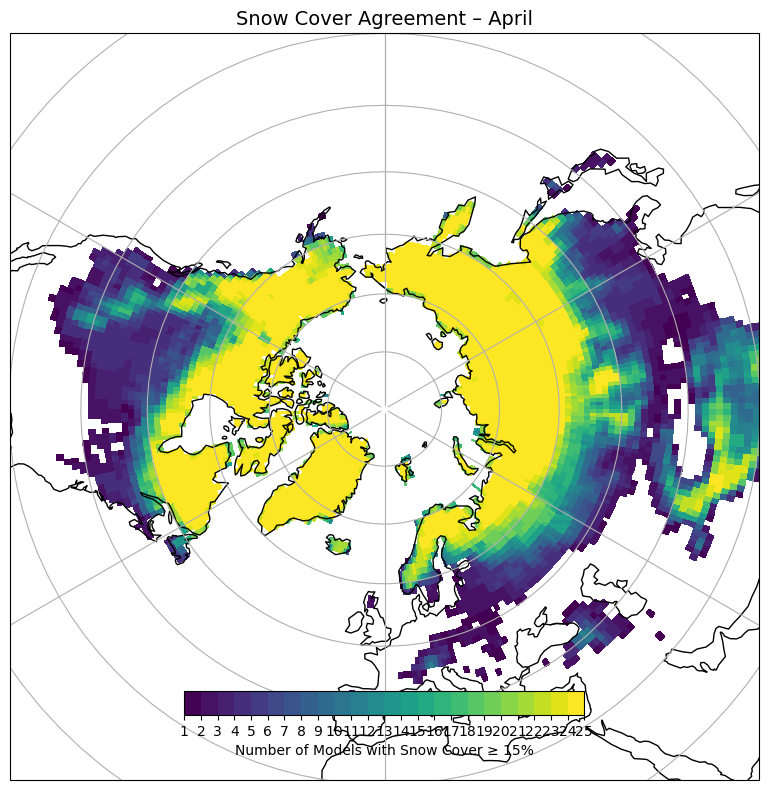

/tmp/ipykernel_2917/4161737850.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


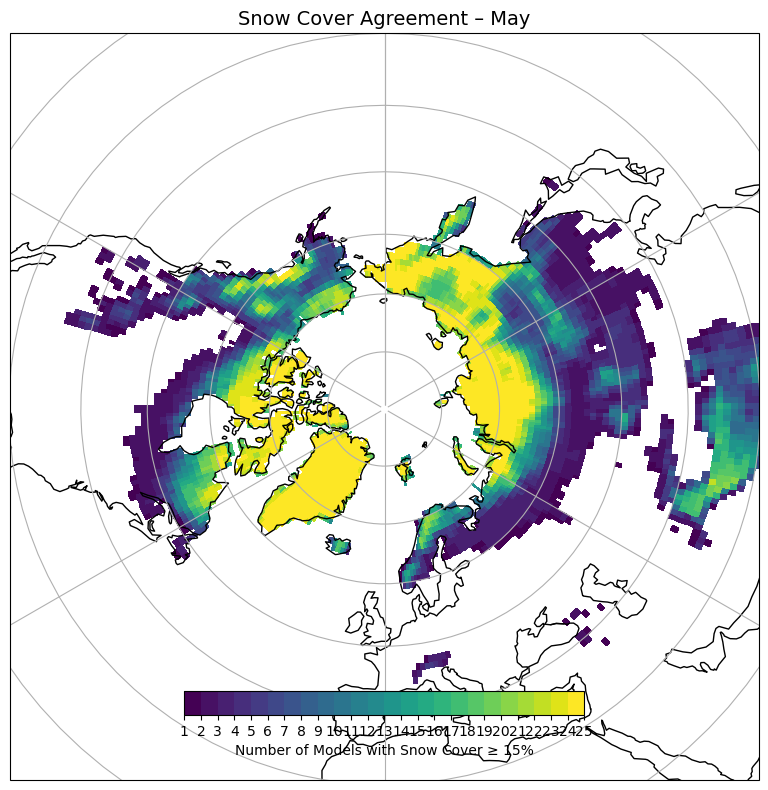

/tmp/ipykernel_2917/4161737850.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


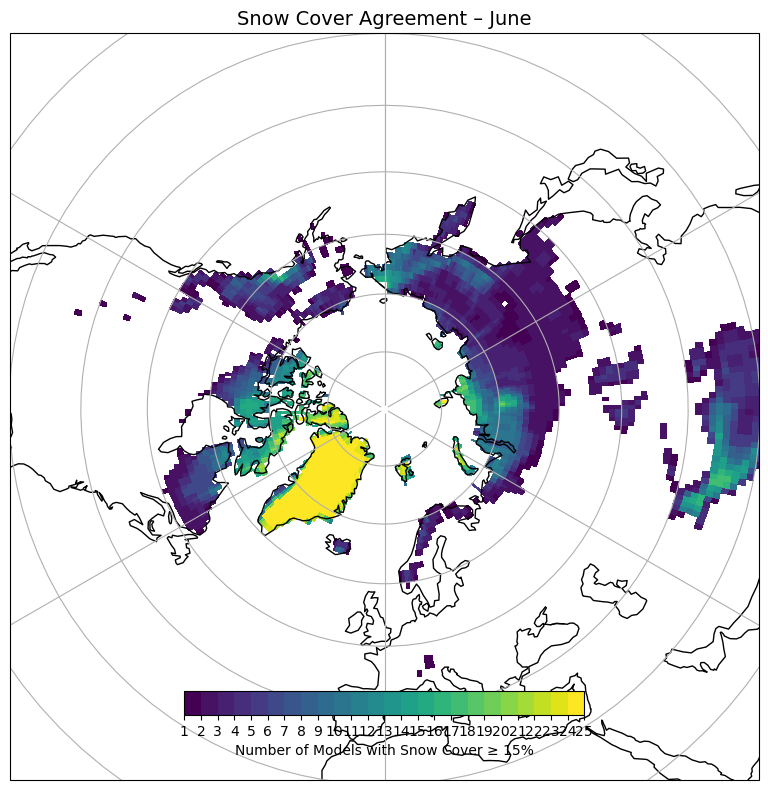

/tmp/ipykernel_2917/4161737850.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


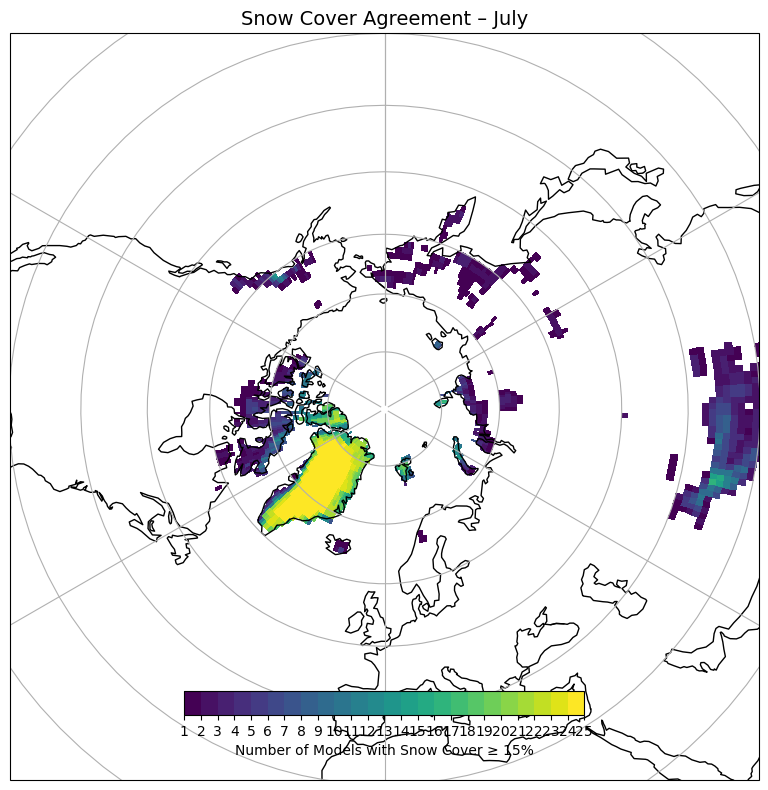

/tmp/ipykernel_2917/4161737850.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


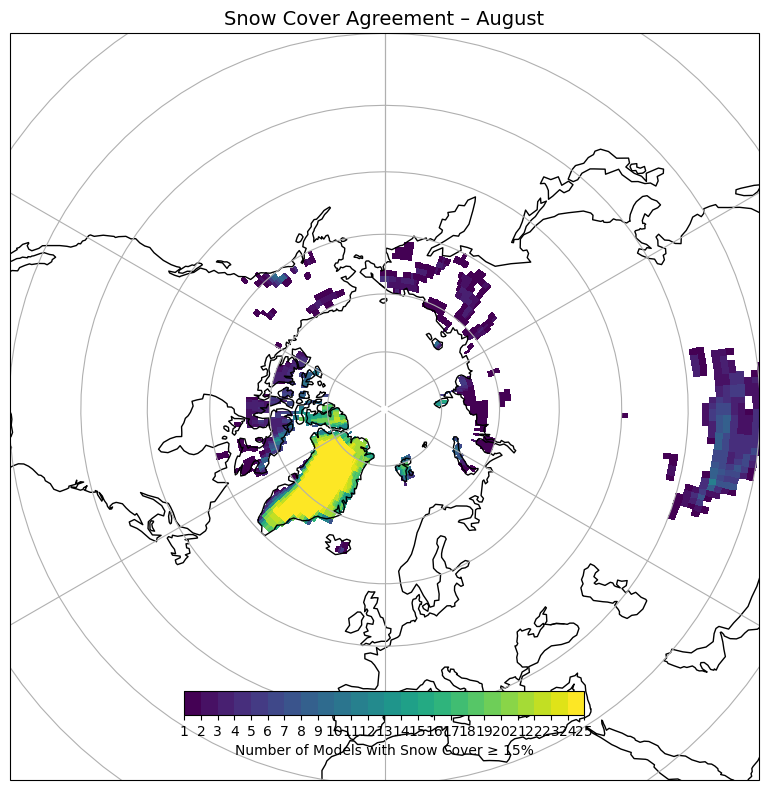

/tmp/ipykernel_2917/4161737850.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


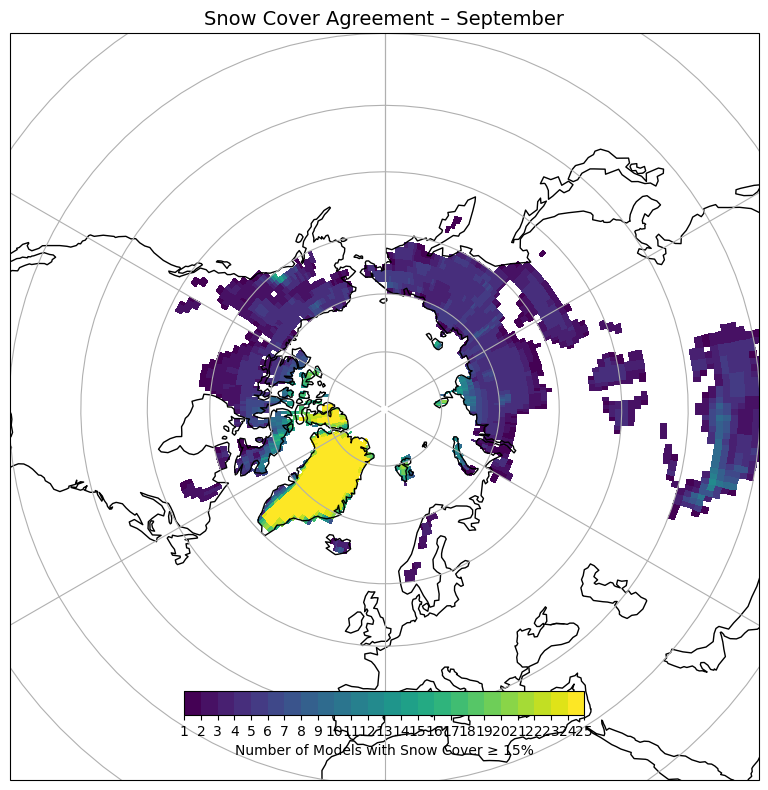

/tmp/ipykernel_2917/4161737850.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


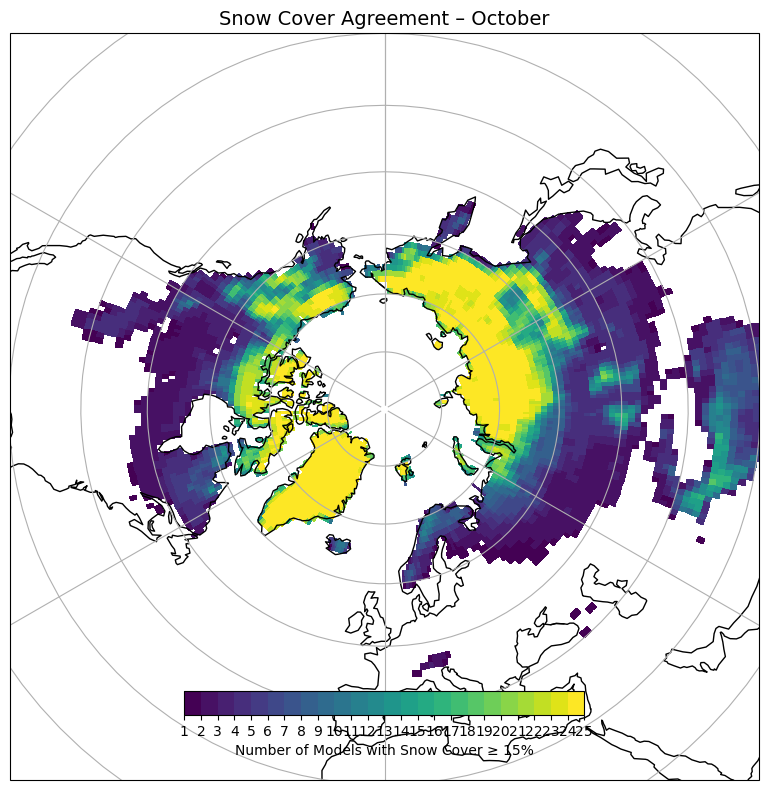

/tmp/ipykernel_2917/4161737850.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


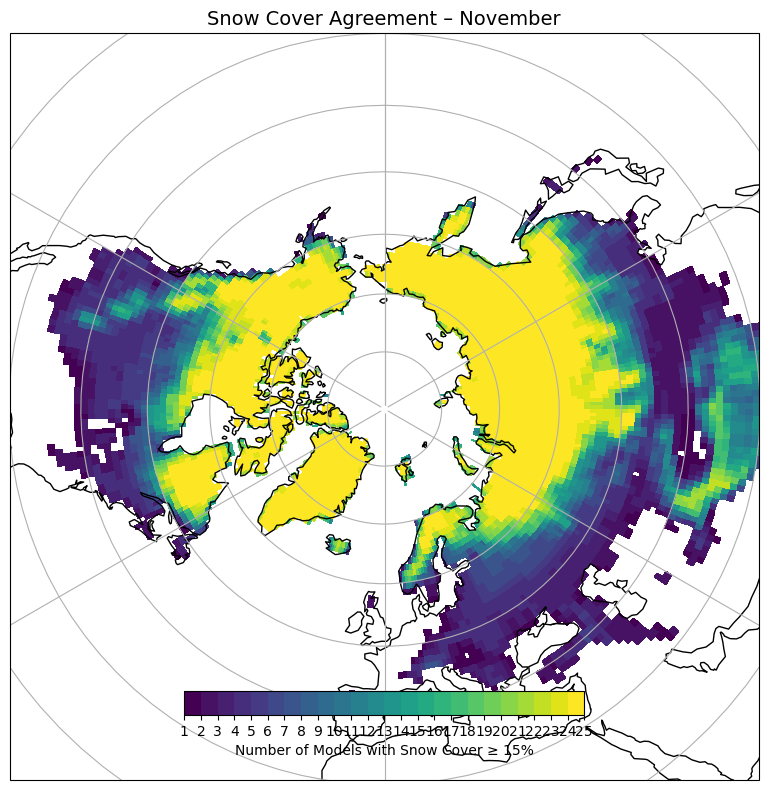

/tmp/ipykernel_2917/4161737850.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


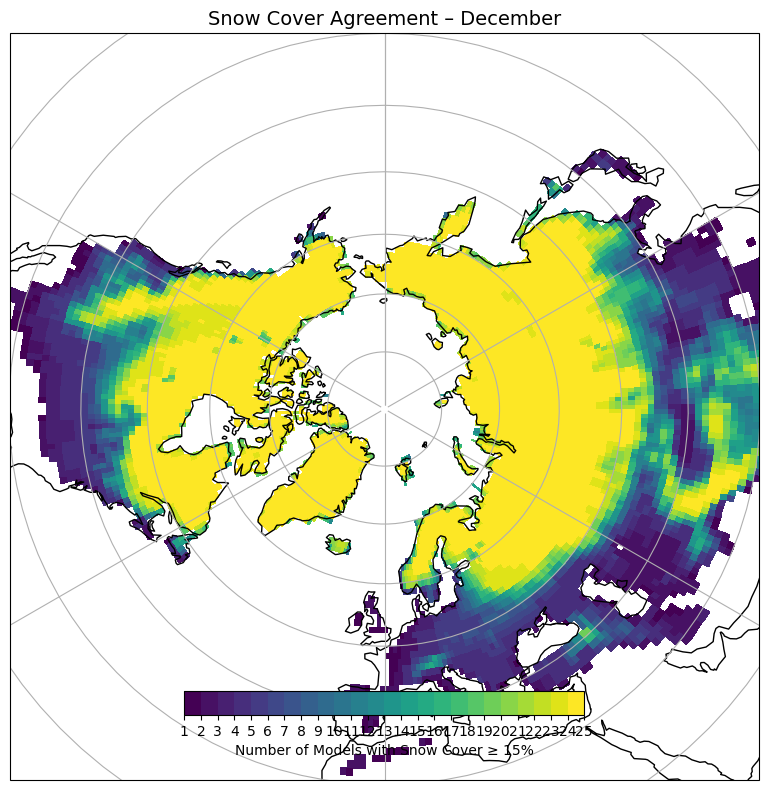

In [88]:
# Paramètres de la colormap discrète
cmap = mpl.cm.viridis
bounds = np.arange(1, 26)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# Masque terrestre (interpolé si besoin)
landmask = (sftlf > 50)
if 'lat' not in landmask.dims or 'lon' not in landmask.dims:
    landmask = landmask.interp_like(monthly_sum.isel(month=0))

# Noms des mois
month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Boucle sur les mois
for month_idx in range(12):
    data = monthly_sum.isel(month=month_idx)
    data_plot = data.where((data > 0) & (landmask))

    # Figure
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

    # Affichage de la neige simulée
    mesh = ax.pcolormesh(
        data_plot['lon'],
        data_plot['lat'],
        data_plot,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm
    )

    # Habillage de la carte
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
    ax.set_title(f"Snow Cover Agreement – {month_names[month_idx]}", fontsize=14)

    # Colorbar
    cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])
    cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='horizontal', ticks=bounds)
    cbar.set_label("Number of Models with Snow Cover ≥ 15%")

    plt.tight_layout()
    plt.show()


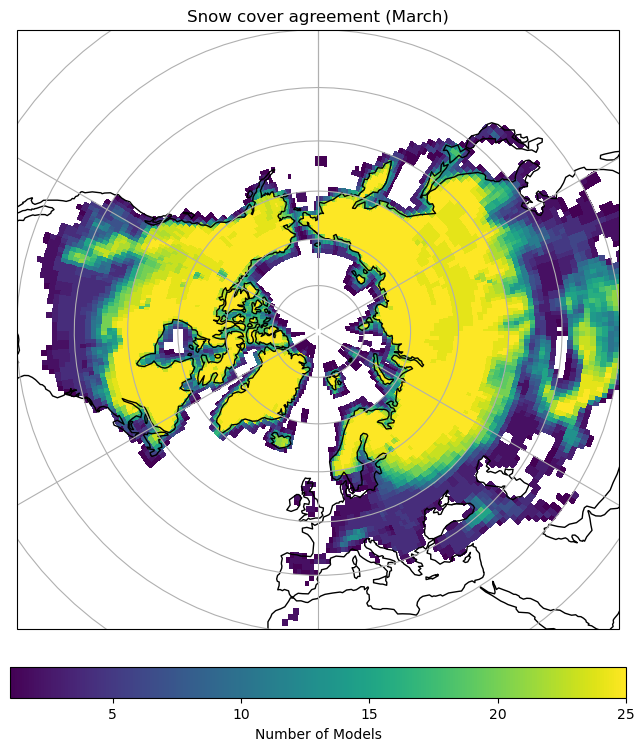

In [73]:
month_idx = 2  # mars
data = monthly_sum.isel(month=month_idx)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

# choisir la bonne grille
landmask = sftlf > 50
data_plot = data.where(data > 0 & land_mask)

# plot
mesh = ax.pcolormesh(
    data_plot['lon'],
    data_plot['lat'],
    data_plot,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    vmin=1,
    vmax=25
)

ax.coastlines()
ax.gridlines(draw_labels=False)
ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())

# couleurs
cbar = plt.colorbar(mesh, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label("Number of Models")

plt.title("Snow cover agreement (March)")
plt.tight_layout()
plt.show()

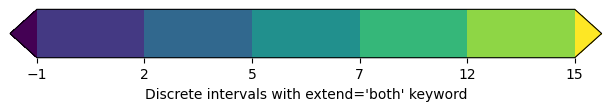

In [79]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

cmap = mpl.cm.viridis
bounds = [-1, 2, 5, 7, 12, 15]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword")

AttributeError: 'DataArray' object has no attribute 'items'

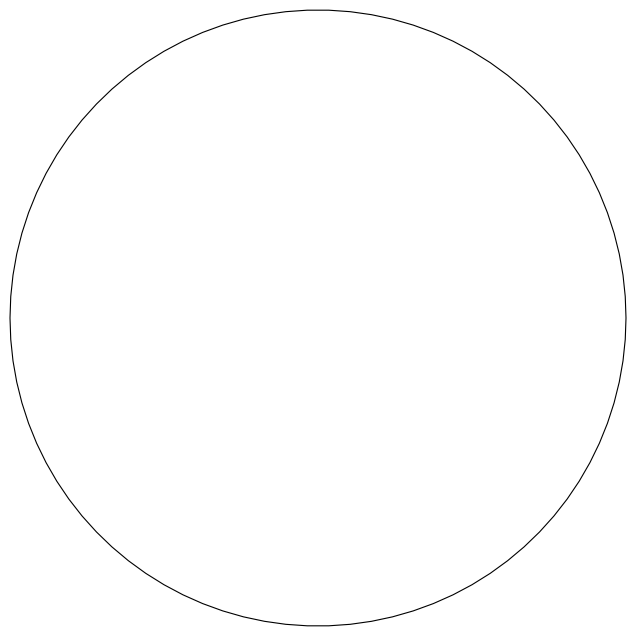

In [72]:
month_idx = 2  # mars (index 2 car indexé à 0)
data = monthly_sum.isel(month=month_idx)

for month_index in range(12):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())

    for label, da in data.items():
        da_month = da.isel(month=month_index)

        mask = (da_month == 1) & land_mask

        lon2d, lat2d = np.meshgrid(da.lon, da.lat)
# Choisir la bonne grille
        data_plot = data.where(data > 0)

# Plot
        mesh = ax.pcolormesh(
            data_plot['lon'],
            data_plot['lat'],
            data_plot,
            transform=ccrs.PlateCarree(),
            cmap='viridis',
            vmin=1,
            vmax=25
        )

# Add features
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())

# Couleurs
    cbar = plt.colorbar(mesh, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar.set_label("Number of Models")

    plt.title("Snow cover agreement (March)")
    plt.tight_layout()
    plt.show()

In [23]:
def harmonize_time(da):
    # Convertir toutes les dates au format datetime64[ns] arrondi au jour
    if not np.issubdtype(da.time.dtype, np.datetime64):
        da['time'] = np.array([np.datetime64(str(t), 'ns') for t in da.time.values])
    # Arrondir au jour près
    da['time'] = da['time'].dt.floor('D')
    return da

def drop_extra_coords(da):
    coords_to_keep = {'time', 'lat', 'lon'}
    drop_coords = set(da.coords) - coords_to_keep
    return da.drop_vars(drop_coords, errors='ignore')

def sum_binary_votes(snow_cover_dict):
    data_arrays = []

    for model, da in snow_cover_dict.items():
        da = harmonize_time(da)
        da = drop_extra_coords(da)
        data_arrays.append(da)

    # Aligner les données sur les temps communs
    common_times = set(data_arrays[0].time.values)
    for da in data_arrays[1:]:
        common_times &= set(da.time.values)

    if not common_times:
        raise ValueError("Aucune date commune entre les modèles après harmonisation des temps.")

    common_times = sorted(common_times)
    data_arrays = [da.sel(time=common_times) for da in data_arrays]

    # Ajouter la dimension 'model'
    data_arrays_named = [
        da.expand_dims(dim={"model": [model_name]})
        for model_name, da in zip(snow_cover_dict.keys(), data_arrays)
    ]

    # Concaténation
    stacked = xr.concat(data_arrays_named, dim="model")

    # Somme binaire par point (lat, lon) pour chaque date
    votes = stacked.sum(dim="model")

    return votes

In [24]:
snow_votes = sum_binary_votes(snow_cover_dict)

ValueError: Aucune date commune entre les modèles après harmonisation des temps.

In [10]:
all_snc = xr.concat(cleaned_snc, dim=xr.DataArray(model_names, dims="model"))

TypeError: cannot compare cftime.DatetimeNoLeap(1995, 1, 16, 12, 0, 0, 0, has_year_zero=True) and Timestamp('1995-01-16 12:00:00') (different calendars)

In [44]:
def ensure_datetime64_or_cftime(snow_cover_dict):
    try:
        # Essaie conversion vers datetime64 (standard calendar)
        snow_cover_dict['time'] = snow_cover_dict.indexes['time'].to_datetimeindex()
    except Exception:
        # Sinon reste en cftime
        snow_cover_dict = xr.decode_cf(snow_cover_dict, use_cftime=True)
    return snow_cover_dict

def seasonal_sum_then_mean(snow_cover_dict):
    # Somme des champs binaires de tous les modèles
    data_stack = xr.concat(snow_cover_dict.values(), dim="model")
    summed = data_stack.sum(dim="model")  # Résultat : (time, lat, lon)

    # Moyenne saisonnière
    seasonal_sum = summed.groupby("time.season").mean("time", skipna=True)

    return seasonal_sum

In [48]:
import xarray as xr
import cftime

def ensure_compatible_time(da):
    """
    S'assure que l'axe 'time' est dans un format utilisable pour le groupby saisonnier.
    Gère les calendriers non standards (comme noleap, 360_day, etc).
    """
    if hasattr(da.indexes, 'time'):
        try:
            # Essaie de convertir en datetime64 si possible
            da['time'] = da.indexes['time'].to_datetimeindex()
        except Exception:
            # Si impossible, on ne touche pas
            pass
    return da

def seasonal_sum_then_mean(snow_cover_dict):
    """
    Calcule la somme des champs binaires de tous les modèles,
    puis la moyenne saisonnière sur cette somme.

    Paramètres :
        snow_cover_dict : dict
            Dictionnaire {nom_modèle: DataArray (time, lat, lon)}

    Retour :
        seasonal_sum : xarray.DataArray
            Moyenne saisonnière du champ binaire cumulé entre modèles.
            Dimensions: season, lat, lon
    """
    data_list = []

    for model_name, da in snow_cover_dict.items():
        da = ensure_compatible_time(da)
        data_list.append(da.expand_dims(model=[model_name]))

    # Concatène les modèles dans une dimension "model"
    stacked = xr.concat(data_list, dim="model")

    # Somme des modèles à chaque pas de temps
    summed = stacked.sum(dim="model")  # Résultat : (time, lat, lon)

    # Moyenne saisonnière de cette somme
    seasonal_sum = summed.groupby("time.season").mean("time", skipna=True)

    return seasonal_sum


In [49]:
seasonal_snow_votes = seasonal_sum_then_mean(snow_cover_dict)

TypeError: cannot compare cftime.DatetimeNoLeap(1995, 1, 16, 12, 0, 0, 0, has_year_zero=True) and Timestamp('1995-01-16 12:00:00') (different calendars)

In [45]:
snow_cover_dict = ensure_datetime64_or_cftime(snow_cover_dict)
sum_then_seasonal = seasonal_sum_then_mean(snow_cover_dict)

TypeError: can only decode Dataset or DataStore objects

In [32]:
binary_mask

<xarray.DataArray 'snc' (time: 240, lat: 70, lon: 360)> Size: 48MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * time     (time) object 2kB 1995-01-16 00:00:00 ... 2014-12-16 00:00:00
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    type     |S4 4B ...

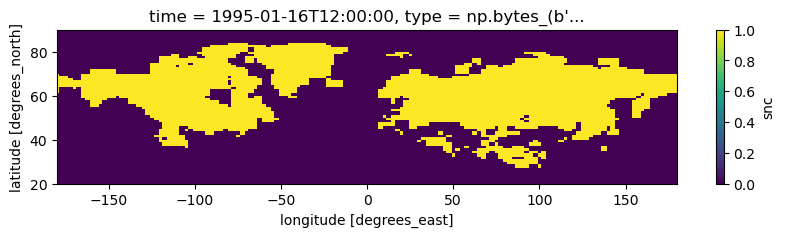

In [39]:
plt.figure(figsize=(10, 2))
snow_cover_dict['IPSL-CM6A-LR'][0].plot()

In [14]:
season_months = {
    "DJF": [12, 1, 2],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11]
}

In [20]:
seasonal_snc_IPSL_CM6A_LR = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = snow_cover_dict["IPSL-CM6A-LR"].sel(month=months_float)
    seasonal_snc_IPSL_CM6A_LR[season] = da_sel.mean(dim="month", skipna=True)

KeyError: "'month' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'time': 1980, 'lat': 70, 'lon': 360})"

In [19]:
snow_cover_dict["IPSL-CM6A-LR"]

<xarray.DataArray 'snc' (time: 1980, lat: 70, lon: 360)> Size: 200MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T12...
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    type     |S255 255B ...